# Import Files

In [1]:
import pandas as pd
import numpy as np
import warnings 
import json
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import matplotlib.pyplot as plt
import datetime as dt 
from scipy import stats
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth',1000)
pd.set_option('display.max_columns',100)

In [2]:
# get lsit of files in the directory 
from os import listdir
combined_events = listdir("combined_events")
course_structures = listdir("course_structure")

## EDIT HERE

In [386]:
# decide which files to import 
sequence = 3
remove_outliers = 'yes'

In [387]:
if remove_outliers == 'yes':
    outliers = 'outliers_removed_'
else:
    outliers = ""

In [388]:
course_structure = pd.read_csv('course_structure/'+course_structures[sequence])
data = pd.read_csv("combined_events/"+combined_events[sequence])

In [389]:
# ECN Easter Egg Segregation 
#users_by_group = pd.read_csv('users_by_group.csv')
#data = users_by_group.merge(data,on='username', how = 'left')
#data = data[data['group'] == 'Group A']

In [390]:
# sort values
data = data.sort_values(by=['username','time'])
# convert to datetime
data['time'] = pd.to_datetime(data['time'])
data['course_start'] = pd.to_datetime(data['course_start'])

In [391]:
# remove null usernames
data = data.dropna(subset=['username'])

In [392]:
# remove users who did not make it past the first chapter
max_chapter = data.groupby('username',as_index=False).agg({'chapter_order':'max'},axis=1)
max_chapter = max_chapter.rename({'chapter_order':'max_chapter_order'},axis=1)
data = max_chapter.merge(data,on='username', how = 'left')
data = data[data['max_chapter_order'] > 1] 

## Remove Staff Users

In [393]:
# find Course Start Date
course_start_date = pd.DataFrame(data['course_start'].unique()).loc[0]
# determine who the staff members are -- if they are active before the course begins, we assume that they are not students
staff = data[data['time'] <= course_start_date[0]]['username'].unique()
# remove staff
data = data[~data['username'].isin(staff)]

## Feature: Size of Largest Gap

In [394]:
data['last_time'] = pd.DataFrame(data.groupby('username')['time'].shift(periods = 1) )
data['time'] = pd.to_datetime(data['time'])
data['last_time'] = pd.to_datetime(data['last_time'])
data['delta'] = data['time'] - data['last_time'] 

In [395]:
by_students = data.loc[:,['username','delta']].dropna().groupby('username', as_index = False).max()

In [396]:
# rename column 
max_gap_feature = by_students.rename({"delta":"max_gap_feature"},axis=1)

In [397]:
max_gap_feature['max_gap_feature'] = max_gap_feature['max_gap_feature'].dt.seconds

## Feature: Amount of Activity

In [398]:
event_count_feature = data.groupby('username',as_index = False).agg({'event':'count'})

In [399]:
event_count_feature = event_count_feature.rename({'event':'event_count_feature'},axis=1)

## Feature: Average Session Time

In [400]:
data_session = data.groupby(['username','session'],as_index=False).agg({'time':['min','max']})

In [401]:
data_session.columns = ['username','session','time_min','time_max']
data_session['delta'] = data_session['time_max']-data_session['time_min']

In [402]:
session_time_feature = data_session.groupby('username',as_index = False)['delta'].median(numeric_only=False)

In [403]:
session_time_feature = session_time_feature.rename({'delta':'session_time_feature'},axis=1)

In [404]:
session_time_feature['session_time_feature'] = session_time_feature['session_time_feature'].dt.seconds

## Feature: Amount of Activity / Total Time Spent (measure productivity) 

In [405]:
productivity_feature = session_time_feature.merge(event_count_feature, on = 'username')

In [406]:
productivity_feature['productivity_feature'] = productivity_feature['event_count_feature'] / productivity_feature['session_time_feature']

In [407]:
productivity_feature = productivity_feature.drop(['session_time_feature','event_count_feature'],axis=1)

In [408]:
productivity_feature = productivity_feature.replace([np.inf, -np.inf], np.nan)

In [409]:
productivity_feature = productivity_feature.dropna()

## Feature: Video Events 

In [410]:
# convert course_structure columns to all lowercase 
course_structure.columns = map(str.lower, course_structure.columns)

In [411]:
# only take relevant columns 
course_smallestunit = course_structure.loc[:,['smallestunit_id','smallestunit_type']]
# drop duplicates 
course_smallestunit = course_smallestunit.drop_duplicates() 

In [412]:
# merge with course_structure to get smallestunit_type 
video_merged = data.merge(course_smallestunit, how = 'left', on = 'smallestunit_id' ) 

In [413]:
video_events_feature = video_merged[video_merged['smallestunit_type'] == 'video'].groupby('username',as_index = False)['chapter_order'].count()

In [414]:
# rename column
video_events_feature = video_events_feature.rename({'chapter_order':'video_events_feature'}, axis = 1)

## Feature: Weekend vs Weekday Ratio

In [415]:
data['weekday'] = data['time'].dt.weekday

In [416]:
def if_weekend(x):
    if x == 5 or x == 6:
        return 1
    else:
        return 0

In [417]:
data['weekend'] = data.apply(lambda x: if_weekend(x['weekday']), axis=1)

In [418]:
weekend_feature = data.groupby('username',as_index=False).agg({'weekend':'sum', 'event':'count'})

In [419]:
weekend_feature['weekend_feature'] = weekend_feature['weekend']/weekend_feature['event']

In [420]:
weekend_feature = weekend_feature.drop(['weekend','event'],axis=1)

## Feature: Accessed Time Consistency

In [421]:
data['unique_hour_feature'] = data['time'].dt.hour

In [422]:
unique_hour_feature = data.groupby('username',as_index = False).agg({'unique_hour_feature': "nunique"})

## Feature: Average # of times videos paused 

In [423]:
videos_paused = video_merged[(video_merged['name'] == 'pause_video') | (video_merged['name'] == 'edx.video.paused')].groupby(
    ['username','smallestunit_id'],as_index=False).agg({'smallestunit_display_name':'count'})

In [424]:
avg_video_pause_feature = videos_paused.groupby('username',as_index=False).agg({'smallestunit_display_name':'mean'})

In [425]:
avg_video_pause_feature = avg_video_pause_feature.rename({'smallestunit_display_name':'avg_video_pause_feature'}, axis=1)

## Feature: Percentage of Videos paused > 2 times

In [426]:
# total number of videos watched 
total_videos = data[data['name'].str.contains('video')==True].groupby('username',as_index = False).agg({'smallestunit_id':'nunique'})

In [427]:
# total number of videos paused > 2 
video_paused = video_merged[(video_merged['name'] == 'pause_video') | (video_merged['name'] == 'edx.video.paused')]
video_paused = video_paused.groupby(['username','smallestunit_id'],as_index = False).agg({'smallestunit_display_name':'count'}) 

In [428]:
def greater_2(x):
    if x > 2:
        return 1
    else:
        return 0
    
video_paused['greater_2_feature'] = video_paused.apply(lambda x: greater_2(x['smallestunit_display_name']),axis = 1)
video_paused = video_paused.groupby('username',as_index = False).agg({'greater_2_feature':'count'})

In [429]:
greater_2_feature = total_videos.merge(video_paused, how= 'left', on = 'username')

In [430]:
greater_2_feature = greater_2_feature.fillna(0)

In [431]:
greater_2_feature = greater_2_feature.drop(['smallestunit_id'],axis=1)

## Feature: Videos Completed -- Unfinished -- numbers seem off. also need to remove percents > 100 (some videos are paused after they're finished)

In [432]:
video_data = video_merged[video_merged['smallestunit_type'] == 'video']

In [433]:
# get duration of videos 

def get_video_duration(x):
    try:
        string = json.loads(x)
        if 'duration' in string:
            return string['duration']
    except ValueError:
        return np.NaN
    
#video_data['video_time'] = video_data.apply(lambda x: get_video_duration(x['event']),axis=1)
#video_durations = video_data[video_data['video_time'].notnull()].loc[:,['smallestunit_id','video_time']]


In [434]:
#video_durations = video_durations.groupby('smallestunit_id',as_index = False).apply(lambda x: x.mode())
#video_durations = video_durations.reset_index().drop(['level_0','level_1'],axis=1)

In [435]:
def parse_stop_time(x):
    try:
        string = json.loads(x)
        return string['currentTime']
    except ValueError:
        return NaN

In [436]:
stopped_data = video_data[video_data['name'] == 'stop_video']

In [437]:
#stopped_data['stop_time'] = stopped_data.apply(lambda x: parse_stop_time(x['event']),axis=1)

In [438]:
#last_stopped = stopped_data.groupby(['username','smallestunit_id'],as_index=False).agg({'stop_time':'max'})

In [439]:
#video_merged = last_stopped.merge(video_durations, how = 'left', on = 'smallestunit_id')

In [440]:
#video_merged['percent_watched'] = video_merged['stop_time']/video_merged['video_time']

In [441]:
#video_merged.sort_values('percent_watched',ascending=False)

In [442]:
#video_merged.to_csv('video_percent_watched.csv',index=False)

## Feature: Average Number of Days to Complete Chapter

In [443]:
chapter_completion = data.groupby(['username','chapter_order'],as_index = False).agg({'time':['min','max']}, axis = 1)

In [444]:
chapter_completion.columns = ['username','chapter_order','time_min','time_max']

In [445]:
chapter_completion['delta'] = chapter_completion['time_max'] - chapter_completion['time_min'] 

In [446]:
chapter_duration_feature = chapter_completion.groupby('username',as_index = False)['delta'].mean(numeric_only=False)

In [447]:
chapter_duration_feature = chapter_duration_feature.rename({'delta':'chapter_duration_feature'},axis=1)

In [448]:
chapter_duration_feature['chapter_duration_feature'] = chapter_duration_feature['chapter_duration_feature'].dt.seconds

## Feature: How much student studied for midterm

In [449]:
midterm_start = data[data['chapter_order'] == 9].groupby('username',as_index=False).agg({'time':'min'})

In [450]:
midterm_start = midterm_start.rename({'time':'midterm_started_feature'},axis=1)

In [451]:
midterm_start = midterm_start.merge(data[data['chapter_order'] < 9],on='username')
midterm_start = midterm_start[midterm_start['time'] < midterm_start['midterm_started_feature']]

In [452]:
#midterm_started_feature = midterm_start.groupby('username',as_index=False).agg({'midterm_started_feature':'count'},axis=1)

## Feature: # of unique Session IDs

In [453]:
unique_sessions_feature = data.groupby('username',as_index=False).agg({'session':'nunique'})

In [454]:
unique_sessions_feature = unique_sessions_feature.rename({'session':'unique_sessions_feature'},axis=1)


## Feature: Access Count by Category (Forums) 

In [455]:
forum_count_feature = data[data['name'].str.contains('forum') == True]

In [456]:
forum_count_feature = forum_count_feature.groupby('username',as_index=False).agg({'name':'count'})

In [457]:
forum_count_feature = forum_count_feature.rename({'name':'forum_count_feature'},axis=1) 

## Feature: Forum Thread Views

In [458]:
forum_viewed_feature = data[data['name'] == 'edx.forum.thread.viewed'].groupby('username', as_index=False).agg({'name':'count'})

In [459]:
forum_viewed_feature = forum_viewed_feature.rename({'name':'forum_viewed_feature'}, axis=1)

## Feature: Forum Thread Created

In [460]:
forum_created_feature = data[data['name'] == 'edx.forum.thread.created'].groupby('username', as_index=False).agg({'name':'count'})

In [461]:
forum_created_feature = forum_created_feature.rename({'name':'forum_created_feature'}, axis = 1)

## Feature: Forum Response Created

In [462]:
forum_response_feature = data[data['name'] == 'edx.forum.response.created'].groupby('username', as_index=False).agg({'name':'count'})

In [463]:
forum_response_feature = forum_response_feature.rename({'name':'forum_response_feature'}, axis = 1)

## Feature: Forum Comment Created

In [464]:
forum_comment_feature = data[data['name'] == 'edx.forum.comment.created'].groupby('username', as_index=False).agg({'name':'count'})

In [465]:
forum_comment_feature = forum_comment_feature.rename({'name':'forum_comment_feature'}, axis = 1)

## Feature: Average # of times a student watched each video

In [466]:
video_data = video_merged[video_merged['smallestunit_type'] == 'video']

In [467]:
average_video_watch_feature = video_data.groupby(['username','smallestunit_id'],as_index=False).agg({'session':'nunique'},axis=1)

In [468]:
average_video_watch_feature = average_video_watch_feature.groupby('username',as_index=False).agg({'session':'mean'},axis=1)

In [469]:
average_video_watch_feature = average_video_watch_feature.rename({'session':'average_video_watch_feature'},axis=1)

## Feature: Video Speed Changes

In [470]:
video_speed_change_feature = video_merged[video_merged['name'] == 'speed_change_video']

In [471]:
video_speed_change_feature = video_speed_change_feature.groupby('username',as_index=False).agg({'event':'count'},axis=1)

In [472]:
video_speed_change_feature = video_speed_change_feature.rename({'event':'video_speed_change_feature'}, axis=1)

## Feature: Proportion of Video

In [473]:
# get all events
total_events = data.groupby('username',as_index=False).agg({'event':'count'},axis=1)
total_events = total_events.rename({'event':'total_events'},axis=1)

In [474]:
# get video events
video_events = data[data['name'].str.contains('video')==True].groupby('username',as_index=False).agg({'event':'count'},axis=1)
video_events = video_events.rename({'event':'video_events'},axis=1)

In [475]:
video_events_proportion_feature = total_events.merge(video_events, on = 'username', how = 'left') 

In [476]:
video_events_proportion_feature = video_events_proportion_feature.fillna(0)

In [477]:
video_events_proportion_feature['video_events_proportion_feature'] = video_events_proportion_feature['video_events'] / video_events_proportion_feature['total_events'] 

In [478]:
video_events_proportion_feature = video_events_proportion_feature.drop({'total_events','video_events'},axis=1)

## Feature: Average number of days between interactions

In [479]:
data_sorted = data.sort_values(['username','time'], axis=0)

In [480]:
data_sorted['month'] = data_sorted['time'].dt.month
data_sorted['month'] = data_sorted['month'].astype('str')

data_sorted['day'] = data_sorted['time'].dt.day
data_sorted['day'] = data_sorted['day'].astype('str')

data_sorted['year'] = data_sorted['time'].dt.year
data_sorted['year'] = data_sorted['year'].astype('str')

In [481]:
data_sorted['date'] = data_sorted[['month','day','year']].apply(lambda x: '/'.join(x), axis = 1) 

In [482]:
data_sorted['date'] = pd.to_datetime(data_sorted['date'])

In [483]:
avg_date_delta_feature = data_sorted.groupby(['username','date'],as_index = False).agg({'name':'count'},axis=1) 

In [484]:
avg_date_delta_feature = avg_date_delta_feature.drop('name', axis=1)

In [485]:
avg_date_delta_feature = avg_date_delta_feature.sort_values(['username','date'])

In [486]:
avg_date_delta_feature['last_date'] = pd.DataFrame(avg_date_delta_feature.groupby('username')['date'].shift(periods = 1))

In [487]:
avg_date_delta_feature['avg_date_delta_feature'] = avg_date_delta_feature['date'] - avg_date_delta_feature['last_date']

In [488]:
avg_date_delta_feature = avg_date_delta_feature.dropna()

In [489]:
avg_date_delta_feature = avg_date_delta_feature.groupby('username',as_index = False)['avg_date_delta_feature'].mean(numeric_only = False)

In [490]:
avg_date_delta_feature['avg_date_delta_feature'] = avg_date_delta_feature['avg_date_delta_feature'].dt.seconds

## Feature: Avg # of Days needed to complete one chapter

In [491]:
chapter_completion_feature = data_sorted.groupby(['username','chapter_order'],as_index=False).agg({'date':'nunique'},axis=1)

In [492]:
chapter_completion_feature = chapter_completion_feature.groupby('username',as_index=False).agg({'date':'mean'})

In [493]:
chapter_completion_feature = chapter_completion_feature.rename({'date':'chapter_completion_feature'},axis=1)

## Feature: Average number of Videos watched each session

In [494]:
avg_video_per_session_feature = video_data.groupby(['username','session'],as_index=False).agg({'smallestunit_id':'nunique'})

In [495]:
avg_video_per_session_feature = avg_video_per_session_feature.groupby('username',as_index=False).agg({'smallestunit_id':'mean'})

In [496]:
avg_video_per_session_feature = avg_video_per_session_feature.rename({'smallestunit_id':'avg_video_per_session_feature'},axis=1)

## Feature: Total Number of Pauses

In [497]:
video_pause_feature = data[data['name'].str.contains('pause')]

In [498]:
video_pause_feature = video_pause_feature.groupby(['username'],as_index=False).agg({'smallestunit_id':'count'})

In [499]:
video_pause_feature = video_pause_feature.rename({'smallestunit_id':'video_pause_feature'},axis=1)

## Feature: # of Forward Seeks

In [500]:
video_seek = data[data['name'].str.contains('seek')==True]

In [501]:
def get_time(x,when):
    if 'old_time' in x and 'new_time' in x:
        try:
            string = json.loads(x)
            return string[when]
        except ValueError:
            return np.NaN
    else:
        return np.NaN
    
when = ['old_time','new_time']
for i in when:
    video_seek[i] = video_seek.apply(lambda x: get_time(x['event'],i),axis=1)

In [502]:
video_seek['time_delta'] = video_seek['new_time'] - video_seek['old_time']

In [503]:
video_seek['forward_backward'] = ['forward' if x > 0 else 'backward' for x in video_seek['time_delta']]

In [504]:
forward_seek_feature = video_seek.loc[video_seek['forward_backward'] == 'forward'].groupby('username',as_index=False).agg({'forward_backward':'count'},axis=1)

In [505]:
forward_seek_feature = forward_seek_feature.rename({'forward_backward':'forward_seek_feature'},axis=1)

## Feature: # of Backward Seeks

In [506]:
backward_seek_feature = video_seek.loc[video_seek['forward_backward'] == 'backward'].groupby('username',as_index=False).agg({'forward_backward':'count'},axis=1)

In [507]:
backward_seek_feature = backward_seek_feature.rename({'forward_backward':'backward_seek_feature'},axis=1)

## Feature: Problem Grades

In [508]:
problems_feature = data[data.name == 'edx.grades.problem.submitted']

In [509]:
def get_grades(x, grade_type):
    string = json.loads(x)
    return string[grade_type]

grade_types = ['weighted_earned','weighted_possible']

for i in grade_types:
    problems_feature[i] = problems_feature.apply(lambda x: get_grades(x['event'], i),axis=1)


In [510]:
problems_feature = problems_feature.groupby('username',as_index=False).agg({'weighted_earned':'sum','weighted_possible':'sum'})

In [511]:
problems_feature['problems_feature'] = problems_feature['weighted_earned'] / problems_feature['weighted_possible']

In [512]:
problems_feature = problems_feature[['username','weighted_earned','weighted_possible','problems_feature']]

## Feature: Number of Assessments Completed

In [513]:
assessments_completed_feature = data[data.name == 'edx.grades.problem.submitted']

In [514]:
assessments_completed_feature = assessments_completed_feature[['event','smallestunit_id','username']].groupby('username',as_index=False).agg({'smallestunit_id':'nunique'})

In [515]:
# rename column
assessments_completed_feature = assessments_completed_feature.rename({'smallestunit_id':'assessments_completed_feature'},axis=1)

## Feature: When dropped out

In [516]:
max_date_feature = data.groupby('username', as_index = False).agg({'time':'max'})

In [517]:
max_date_feature = max_date_feature.rename({'time':'max_date_feature'},axis=1)

In [518]:
max_date_feature['max_date_feature'] = max_date_feature['max_date_feature'].dt.strftime('%y%j')

# Clustering

In [519]:
features = [max_gap_feature 
            ,event_count_feature
            ,session_time_feature
            ,video_events_feature
           ,weekend_feature
            ,unique_hour_feature
            ,avg_video_pause_feature
            ,greater_2_feature
            ,chapter_duration_feature
#            ,midterm_started_feature
           ,productivity_feature
            ,unique_sessions_feature
            ,forum_count_feature
            ,forum_viewed_feature
            ,forum_created_feature
            ,forum_response_feature
            ,forum_comment_feature
           ,average_video_watch_feature
            ,video_speed_change_feature
            ,avg_date_delta_feature
            ,chapter_completion_feature
            ,avg_video_per_session_feature
            ,video_pause_feature
            ,forward_seek_feature
            ,backward_seek_feature
            ,problems_feature
            ,assessments_completed_feature
            ,max_date_feature
           ]

from functools import reduce

features_final = reduce(lambda left,right: pd.merge(left,right,on='username', how='left'), features)

features_final = features_final.fillna(0)


In [520]:
features_final_for_clust = features_final.drop(['username'],axis=1)

cor = features_final_for_clust.corr() #Calculate the correlation of the above variables
sns.set(rc={'figure.figsize':(9,9)})
#sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [521]:
#sns.heatmap(cor, square = True) #Plot the correlation as heat map

## Scale Features

In [522]:
ss = StandardScaler()
#scaled_features = ss.fit_transform(features_final_for_clust)
# temp -- trying out groups 
features_final_for_clust = features_final

scaled_features = ss.fit_transform(features_final.loc[:,features_final.columns != 'username'])

# end temp
scaled_features = pd.DataFrame(scaled_features)
#temp commented out -- add back later 
#scaled_features.columns = features_final_for_clust.columns
features_final_for_clust = scaled_features 

## Remove Outliers

In [523]:
if remove_outliers == 'yes':
    features_final_for_clust = features_final_for_clust[(np.abs(stats.zscore(features_final_for_clust)) < 3.5).all(axis=1)]
else:
    None

In [524]:
# rejoin to get username 
features_final_for_clust = features_final_for_clust.join(features_final[['username']], how = 'left')

In [525]:
# reset index 
features_final_for_clust = features_final_for_clust.reset_index()

In [526]:
features_final_for_clust_og = features_final_for_clust

In [527]:
#remove username again 
features_final_for_clust = features_final_for_clust.loc[:,features_final.columns != 'username']

## PCA

In [528]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
column_names = ['principal component 1', 'principal component 2']
principalComponents = pca.fit_transform(features_final_for_clust)
principalDf =  pd.DataFrame(data=principalComponents, columns = column_names)
# temp: change to PCA values 
features_final_for_clust = principalDf
pca_components = pd.DataFrame(pca.components_, columns = scaled_features.columns, index = column_names)

In [529]:
# pca component 1
pca_t = pca_components.transpose() 
pca1 = pca_t['principal component 1'].reindex(pca_t['principal component 1'].abs().sort_values(ascending = False).index)

In [530]:
# pca component 2
pca2 = pca_t['principal component 2'].reindex(pca_t['principal component 2'].abs().sort_values(ascending = False).index) 

In [531]:
pca.explained_variance_ratio_

array([0.38120687, 0.09442064])

In [532]:
pca.explained_variance_ratio_.cumsum()

array([0.38120687, 0.47562751])

## Agglomerative Clustering

In [533]:
from sklearn.cluster import AgglomerativeClustering

In [534]:
agg_clust = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean')

In [535]:
agg_clust.fit(features_final_for_clust)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x0000000006DF7978>)

In [536]:
labels = agg_clust.labels_

In [537]:
from sklearn import metrics
metrics.silhouette_score(features_final_for_clust, labels, metric = 'euclidean')

0.5354671659866345

In [538]:
for i in range(2,7): 
    agg_clust = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean')
    agg_clust.fit(features_final_for_clust)
    labels = agg_clust.labels_
    score = metrics.silhouette_score(features_final_for_clust, labels, metric = 'euclidean')
    print(i,'clusters:', round(score,3))

(2, 'clusters:', 0.535)
(3, 'clusters:', 0.456)
(4, 'clusters:', 0.494)
(5, 'clusters:', 0.456)
(6, 'clusters:', 0.415)


In [539]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(X)
    return (clust_labels1)

clust_labels1 = doAgglomerative(features_final_for_clust, 2)
agglomerative = pd.DataFrame(clust_labels1)
features_final_for_clust.insert((features_final_for_clust.shape[1]),'agglomerative',agglomerative)

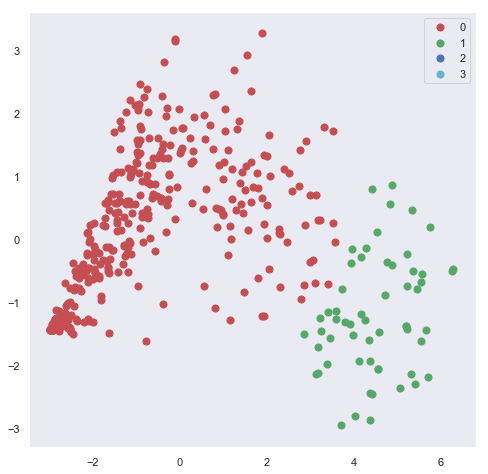

In [540]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
targets = [0,1,2,3]
colors = ['r','g','b','c'] 
for target, color in zip(targets, colors):
    indicesToKeep = features_final_for_clust['agglomerative'] == target
    ax.scatter(features_final_for_clust.loc[indicesToKeep, 'principal component 1']
                ,features_final_for_clust.loc[indicesToKeep,'principal component 2']
                ,c = color
                ,s = 50)
ax.legend(targets) 
ax.grid() 

## K Means

In [541]:
video_pause_feature_test = video_pause_feature[['video_pause_feature']]

In [542]:
from sklearn.cluster import KMeans

In [543]:
clust = KMeans()
kmeans = KMeans(n_clusters=3, random_state = 0).fit(features_final_for_clust[column_names])
y_kmeans = kmeans.predict(features_final_for_clust[column_names])
labels = kmeans.labels_

In [544]:
features_final_for_clust['labels'] = labels

In [545]:
features_final_for_clust.to_csv('clusters.csv',index=False)

In [546]:
from sklearn import metrics

# silhouette score 
metrics.silhouette_score(features_final_for_clust[column_names], labels, metric = 'euclidean')

0.5083877709244718

In [547]:
for i in range(2,7): 
    clust = KMeans()
    kmeans = KMeans(n_clusters=i, random_state = 0).fit(features_final_for_clust[column_names])
    y_kmeans = kmeans.predict(features_final_for_clust[column_names])
    labels = kmeans.labels_
    score = metrics.silhouette_score(features_final_for_clust[column_names], labels, metric = 'euclidean')
    print(i,'clusters:', round(score,3))

(2, 'clusters:', 0.556)
(3, 'clusters:', 0.508)
(4, 'clusters:', 0.506)
(5, 'clusters:', 0.47)
(6, 'clusters:', 0.438)


In [548]:
features_final_for_clust['labels'].value_counts()

0    159
2    156
1     92
Name: labels, dtype: int64

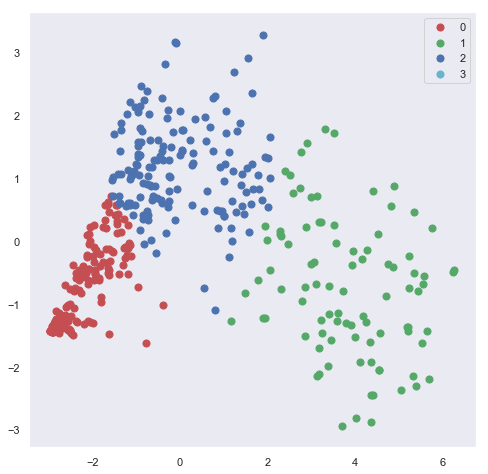

In [549]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
targets = [0,1,2,3]
colors = ['r','g','b','c']
for target, color in zip(targets, colors):
    indicesToKeep = features_final_for_clust['labels'] == target
    ax.scatter(features_final_for_clust.loc[indicesToKeep, 'principal component 1']
             ,features_final_for_clust.loc[indicesToKeep,'principal component 2']
             , c = color
             , s = 50)
ax.legend(targets)
ax.grid() 

In [550]:
for i in range(3):
    print(i, ":", features_final_for_clust[features_final_for_clust['labels'] == i]['principal component 1'].mean())

(0, ':', -2.175119733262517)
(1, ':', 3.814709150399215)
(2, ':', -0.0327513092819728)


In [551]:
for i in range(3):
    print(i, ":", features_final_for_clust[features_final_for_clust['labels'] == i]['principal component 2'].mean())

(0, ':', -0.725971746488215)
(1, ':', -0.7259462819030782)
(2, ':', 1.1680549078635214)


In [552]:
# rejoin to get username 
features_final_for_clust = features_final_for_clust.join(features_final_for_clust_og[['username']], how = 'left')

In [553]:
users_by_group = pd.read_csv('users_by_group.csv') 
features_final_for_clust = users_by_group.merge(features_final_for_clust,on='username', how = 'right') 

## Write to CSV Files

In [555]:
# to_csv 

features_final_for_clust.to_csv('cluster_results/'+outliers+course_structures[sequence],index=False)
pd.DataFrame(pca1).to_csv('cluster_results/PCA/pca1_'+outliers+course_structures[sequence])
pd.DataFrame(pca2).to_csv('cluster_results/PCA/pca2_'+outliers+course_structures[sequence])

## Rejoin Data

In [4603]:
#features_final_for_clust['username'] = features_final['username'] 
#clusters = data.merge(features_final_for_clust, on = 'username', how = 'inner')
# convert usernames to strings 
#clusters['username'] = clusters['username'].astype('str')

#clusters.to_excel('clusters_all.xlsx',index=False)
#clusters['agglomerative'].value_counts()
#clusters['labels'].value_counts()

## Join PCA Data

In [ ]:
# get lsit of files in the directory 
pca_files = listdir("cluster_results/PCA")


In [ ]:
combined_pca = pd.DataFrame(columns={'Unnamed: 0'})
for i in range(len(pca_files)):
    file = pd.read_csv('cluster_results/PCA/'+pca_files[i])
    file = file.rename({file.columns[1]: pca_files[i] },axis=1)
    combined_pca = combined_pca.merge(file, on = 'Unnamed: 0', how = 'outer')

In [ ]:
combined_pca.to_csv('pca_combined.csv',index=False)